# Fourth Experiment

Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 1
    - coreLimit: "2000m"
    - instances: 2
    - memory: "1500m"

Start 27-04-2025 18:00

Stop 27-04-2025 19:22

Commit 4611fbdb747d1d453882a8ddc5204f4af087a047

`"max.in.flight.requests.per.connection": 1`

In [2]:
import pandas as pd
from pandas.tseries.frequencies import to_offset

experiment_name = "fourth_experiment"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-19_35_23-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-19_38_10-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [3]:
def fix_timestamps_timezone(df: pd.DataFrame) -> pd.DataFrame:
    # Corrigindo 'source_timestamp' que está como São Paulo mas deveria ser UTC
    if df["source_timestamp"].dtype != "datetime64[ns]":
        df["source_timestamp"] = pd.to_datetime(df["source_timestamp"])
        
    # Adiciona 3 horas e seta fuso como UTC
    df["source_timestamp"] = (
        df["source_timestamp"]
        - pd.Timedelta(hours=3)
    )
    try:
        df["source_timestamp"] = df["source_timestamp"].dt.tz_convert(None)
    except:
        pass
    # df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")
    # df["landing_timestamp"] = df["landing_timestamp"].dt.tz_convert("UTC")

    return df

In [4]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [5]:
def calculate_latencies(df: pd.DataFrame) -> pd.DataFrame:
    df["source_kafka_latency"] = (df["timestamp"] - df["source_timestamp"]).dt.total_seconds()
    df["kafka_landing_latency"] = (df["landing_timestamp"] - df["timestamp"]).dt.total_seconds()

    return df

In [6]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

There was a broker replica failure on edge just before 17h20. So a filter was applied after this time to observe normal processing conditions.

In [7]:
# 1. Encontrar o intervalo comum entre os dois dataframes
# start_time = max(df_cloud["source_timestamp"].min(), df_edge["source_timestamp"].min())
start_time = pd.Timestamp("2025-04-27 15:35:00")
end_time = min(df_cloud["source_timestamp"].max(), df_edge["source_timestamp"].max())

# 2. Filtrar ambos os dataframes para esse intervalo
df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/tmp/ipykernel_27174/3548571649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxplot, x="Environment", y="source_kafka_latency", palette=custom_palette)


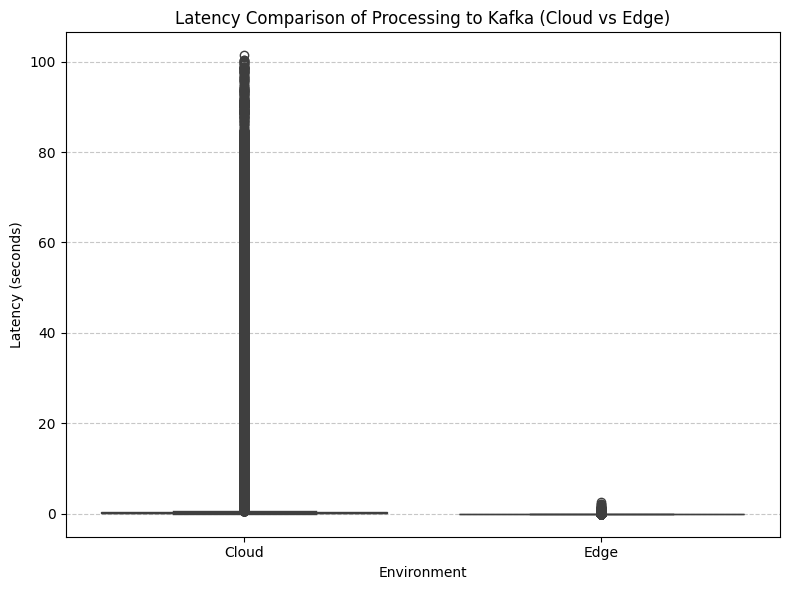

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors for each category
custom_palette = {
    "Cloud": "#1f77b4",  # blue
    "Edge": "#ff7f0e"    # orange
}

# 1. Criar cópias dos dataframes com coluna de origem
df_cloud_box = df_cloud_filtered[["source_kafka_latency"]].copy()
df_cloud_box["Environment"] = "Cloud"

df_edge_box = df_edge_filtered[["source_kafka_latency"]].copy()
df_edge_box["Environment"] = "Edge"

# 2. Concatenar os dois
df_boxplot = pd.concat([df_cloud_box, df_edge_box], ignore_index=True)

# 3. Plotar com Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_boxplot, x="Environment", y="source_kafka_latency", palette=custom_palette)
plt.title("Latency Comparison of Processing to Kafka (Cloud vs Edge)")
plt.ylabel("Latency (seconds)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

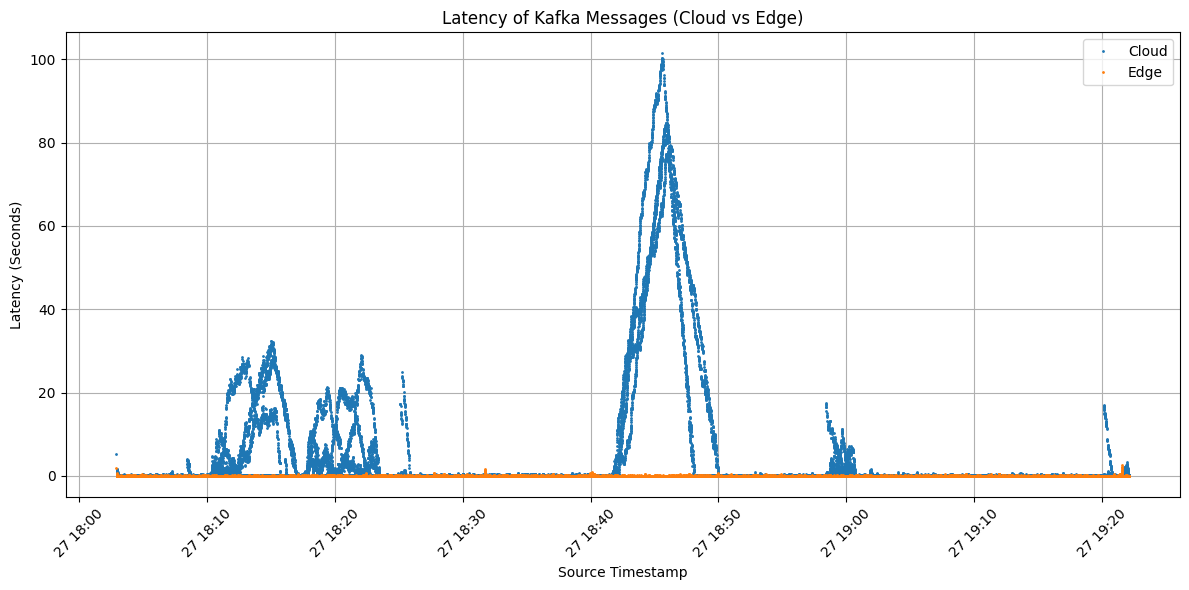

In [9]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_cloud_filtered['source_timestamp'], df_cloud_filtered['source_kafka_latency'], label='Cloud', marker='o', linestyle='none', markersize=1)
plt.plot(df_edge_filtered['source_timestamp'], df_edge_filtered['source_kafka_latency'], label='Edge', marker='o', linestyle='none', markersize=1)
plt.xlabel('Source Timestamp')
plt.ylabel('Latency (Seconds)')
plt.title('Latency of Kafka Messages (Cloud vs Edge)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Statistics:
                 mean    median        std
Environment                               
Cloud        5.331662  0.121592  14.802481
Edge         0.029315  0.025984   0.042080


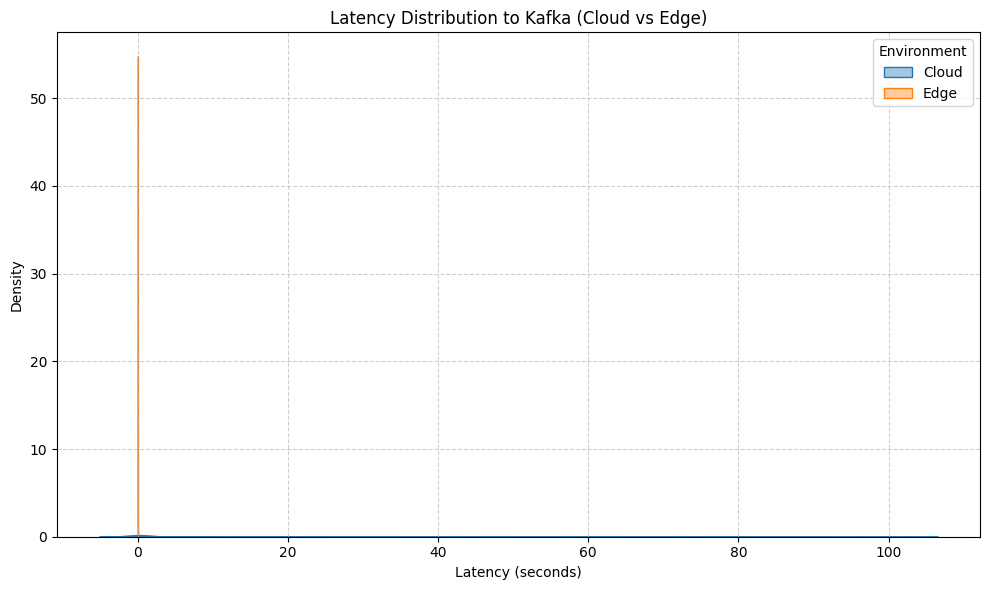

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Unir os dados com coluna de origem
df_cloud_kde = df_cloud_filtered[["source_kafka_latency"]].copy()
df_cloud_kde["Environment"] = "Cloud"

df_edge_kde = df_edge_filtered[["source_kafka_latency"]].copy()
df_edge_kde["Environment"] = "Edge"

df_kde = pd.concat([df_cloud_kde, df_edge_kde], ignore_index=True)

# 2. Calcular estatísticas
stats = df_kde.groupby("Environment")["source_kafka_latency"].agg(["mean", "median", "std"])
print("📊 Statistics:")
print(stats)

# 3. Plotar a curva de distribuição
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde, x="source_kafka_latency", hue="Environment", fill=True, common_norm=False, alpha=0.4)

plt.title("Latency Distribution to Kafka (Cloud vs Edge)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_7243/2530671441.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxplot, x="Environment", y="kafka_landing_latency", palette=custom_palette)


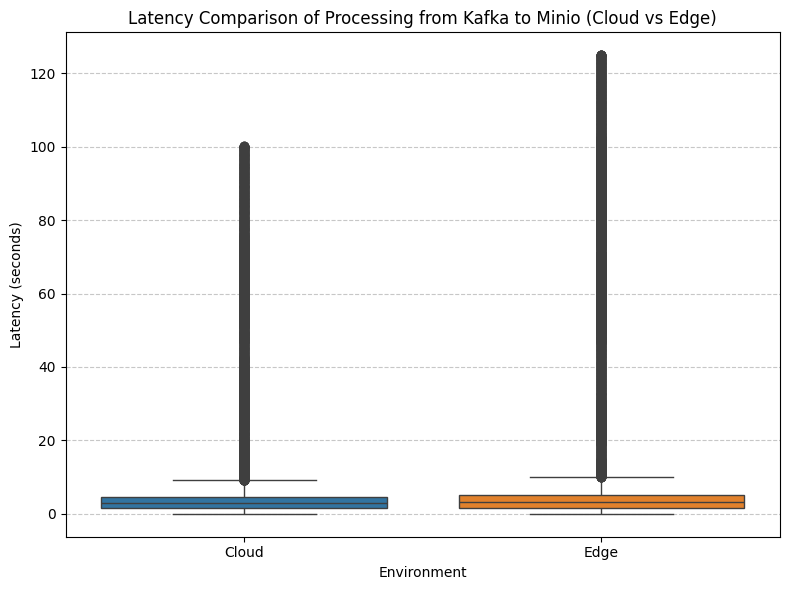

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors for each category
custom_palette = {
    "Cloud": "#1f77b4",  # blue
    "Edge": "#ff7f0e"    # orange
}

# 1. Criar cópias dos dataframes com coluna de origem
df_cloud_box = df_cloud_filtered[["kafka_landing_latency"]].copy()
df_cloud_box["Environment"] = "Cloud"

df_edge_box = df_edge_filtered[["kafka_landing_latency"]].copy()
df_edge_box["Environment"] = "Edge"

# 2. Concatenar os dois
df_boxplot = pd.concat([df_cloud_box, df_edge_box], ignore_index=True)

# 3. Plotar com Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_boxplot, x="Environment", y="kafka_landing_latency", palette=custom_palette)
plt.title("Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")
plt.ylabel("Latency (seconds)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

For the data lake processing cloud performed better in average, but edge seems to have less standard deviation. 

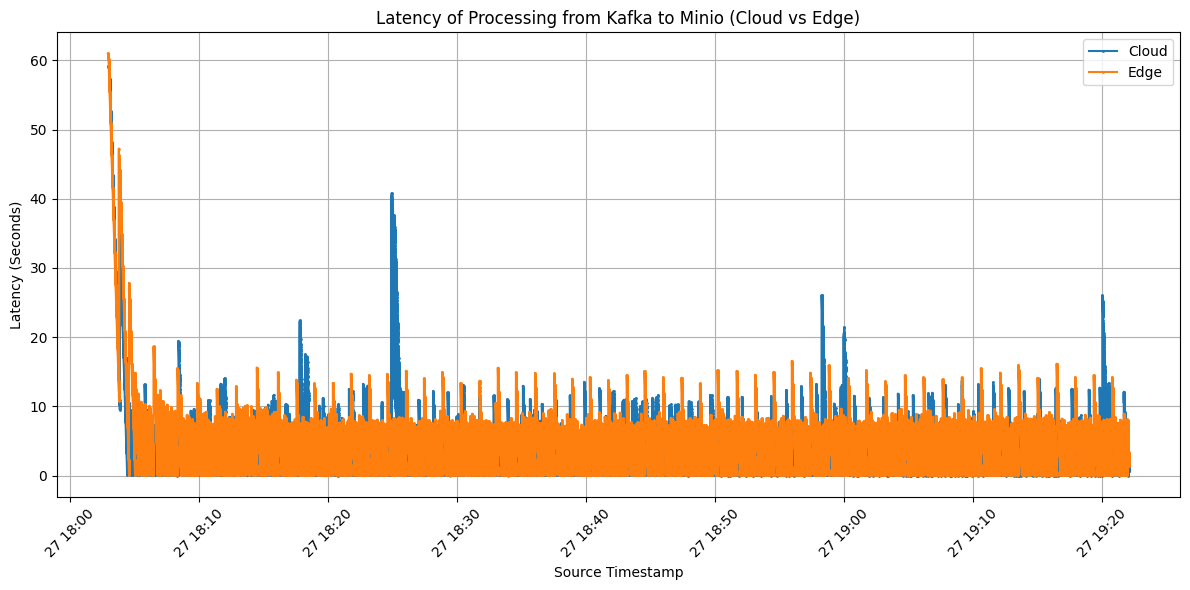

In [11]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_cloud_filtered['source_timestamp'], df_cloud_filtered['kafka_landing_latency'], label='Cloud', marker='o', markersize=1)
plt.plot(df_edge_filtered['source_timestamp'], df_edge_filtered['kafka_landing_latency'], label='Edge', marker='o', markersize=1)
plt.xlabel('Source Timestamp')
plt.ylabel('Latency (Seconds)')
plt.title('Latency of Processing from Kafka to Minio (Cloud vs Edge)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Statistics:
                 mean  median       std
Environment                            
Cloud        4.638419   3.739  5.240731
Edge         5.236183   4.501  5.284024


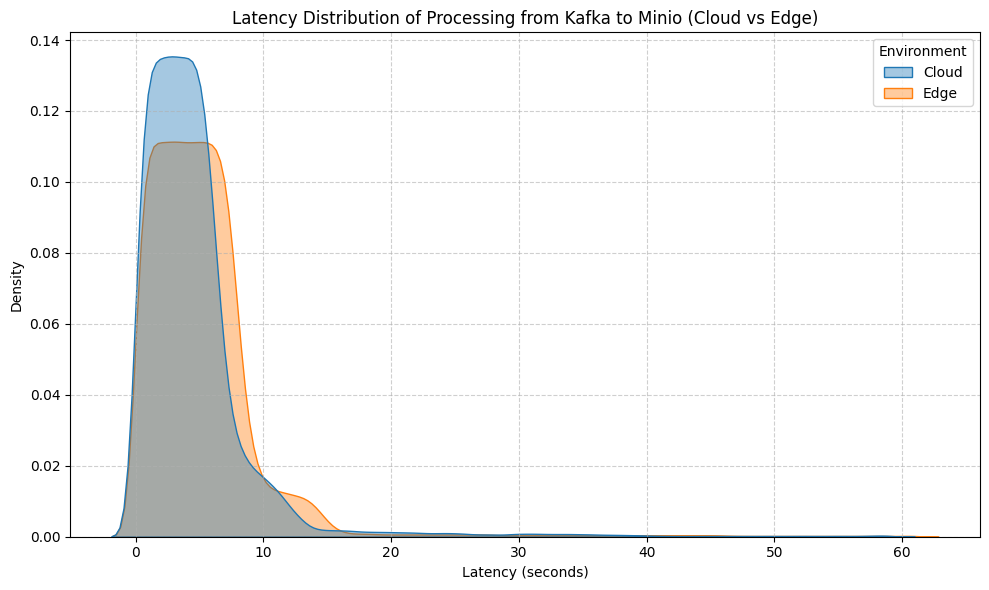

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Unir os dados com coluna de origem
df_cloud_kde = df_cloud_filtered[["kafka_landing_latency"]].copy()
df_cloud_kde["Environment"] = "Cloud"

df_edge_kde = df_edge_filtered[["kafka_landing_latency"]].copy()
df_edge_kde["Environment"] = "Edge"

df_kde = pd.concat([df_cloud_kde, df_edge_kde], ignore_index=True)

# 2. Calcular estatísticas
stats = df_kde.groupby("Environment")["kafka_landing_latency"].agg(["mean", "median", "std"])
print("📊 Statistics:")
print(stats)

# 3. Plotar a curva de distribuição
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde, x="kafka_landing_latency", hue="Environment", fill=True, common_norm=False, alpha=0.4)

plt.title("Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
